In [2]:
# Set up your Julia environment.
using LowRankApprox
using DataFrames
using PyPlot

# Load the functions defined for this project.
include("../code/julia/mixSQP_time.jl");
include("../code/julia/ash.jl");

In [4]:
function sim(n; mult = 1.3)
    n_half = round(Int,n/2);
    srand(1);
    x = [randn(n_half);3*randn(n-n_half)]; s = ones(n);
    out = ash(x,s, lowrank = "qr")[5];
    return out
end

t = sim(1000); # check if works well

n = 4000 * 4.^(1:3);
for i = 1:3
    t = [t sim(n[i])];
end
t = t[:,2:end]';

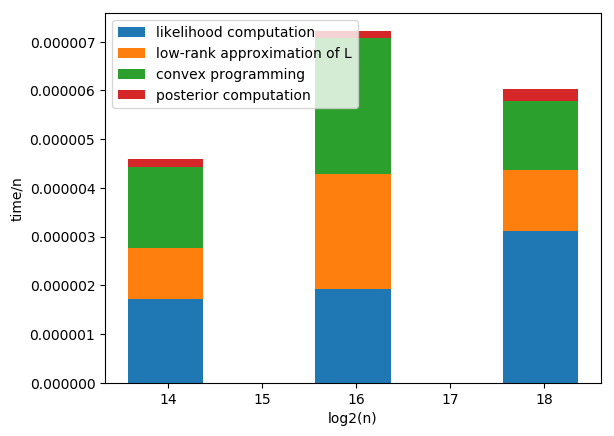

PyObject <matplotlib.legend.Legend object at 0x132d21d90>

In [5]:
fig, ax = subplots()
ax[:bar](log2.(n),t[:,1]./n)
ax[:bar](log2.(n),t[:,2]./n, bottom = t[:,1]./n)
ax[:bar](log2.(n),t[:,3]./n, bottom = sum(t[:,1:2],2)[:]./n)
ax[:bar](log2.(n),t[:,4]./n, bottom = sum(t[:,1:3],2)[:]./n)
xlabel("log2(n)")
ylabel("time/n")
ax[:legend](["likelihood computation";"low-rank approximation of L";"convex programming";"posterior computation"])

# they are in the same scale (time per n).
# For smaller n, other issues (e.g. memory allocation) take considerable amount of time.

## Session information

The section gives information about the computing environment used to generate the results contained in this
manuscript, including the version of Julia, Python and the Julia packages. 

In [6]:
Pkg.status("LowRankApprox")
Pkg.status("DataFrames")
Pkg.status("PyPlot")

 - LowRankApprox                 0.1.0
 - DataFrames                    0.10.1
 - PyPlot                        2.3.2


In [7]:
versioninfo()

Julia Version 0.6.2
Commit d386e40c17 (2017-12-13 18:08 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin14.5.0)
  CPU: Intel(R) Core(TM) i7-7567U CPU @ 3.50GHz
  WORD_SIZE: 64
  BLAS: libopenblas (USE64BITINT DYNAMIC_ARCH NO_AFFINITY Prescott)
  LAPACK: libopenblas64_
  LIBM: libopenlibm
  LLVM: libLLVM-3.9.1 (ORCJIT, broadwell)
